<a href="https://colab.research.google.com/github/yohanesnuwara/differential-equations/blob/master/PDEs/fd_ac2d_vertical_borehole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("classic")

In [ ]:
def calculate_transmitter_receiver_spacing(D, Z, Smud, Sf, Sa):
  return (D * (np.sqrt((Smud**2-Sf**2)/(Sa-Sf)**2) - np.sqrt((Smud**2-Sa**2)/(Sa-Sf)**2)))+(2*Z*np.sqrt((Sa+Sf)/(Sa-Sf)))

D = 8.5/12 # Borehole diameter, in to ft
Z = 6/12 # Altered zone thickness, in to ft
Sf = 100 # Virgin zone slowness, us/ft 
Sa = 130 # Altered zone slowness, us/ft 
Smud = 200 # Mud slowness, us/ft 

dtr = calculate_transmitter_receiver_spacing(D, Z, Smud, Sf, Sa)
print("Spacing between transmitter and receiver must be > {:.3f} ft".format(dtr))

Spacing between transmitter and receiver must be > 3.270 ft


In [2]:
from matplotlib import animation
from IPython.display import HTML

In [32]:
input = [nx,nz,nt,dx,dt,c0,isx,isz,ist,f0,isnap,T,nop]
p0 = [p, pold, pnew, pxx, pzz]

In [62]:
def borehole_ac2d(input, p0, model_type):
  # Unwrap input
  nx,nz,nt,dx,dt,c0,isx,isz,ist,f0,isnap,T,nop = input
  p, pold, pnew, pxx, pzz = p0 # Initial conditions

  # Select model
  c = np.zeros((nz, nx))

  if model_type == "homogeneous":
      c += c0  
  elif model_type == "bhvertical":
      c += c0
      c[:, nx // 2 - 5: nx // 2 + 5] *= 0.8 
  elif model_type == "bhvertical_without_mud":
      c += c0
      c[:, nx // 2 - 5: nx // 2 + 5] *= 0.8 # borehole  
  elif model_type == "bhvertical_mud":
      c += c0
      c[:, nx // 2 - 7: nx // 2 + 7] *= 0.7 # mud 
      c[:, nx // 2 - 5: nx // 2 + 5] *= 0.8 # borehole    
  elif model_type == "bhvertical_contact":
      c += c0
      c[:, nx // 2 - 7: nx // 2 + 7] *= 0.7 # mud    
      c[:, nx // 2 - 5: nx // 2 + 5] *= 0.8 # borehole 
      
      # Oil-saturated zone at bottom
      c_oil = .9
      c[75:,:nx // 2 - 7] *= c_oil  
      c[75:,nx // 2 + 7:] *= c_oil        

  # Source time function Gaussian
  src = np.empty(nt + 1)
  for it in range(nt):
      src[it] = np.exp(-1.0 / T ** 2 * ((it - ist) * dt) ** 2)

  src = np.diff(src) / dt
  src[nt - 1] = 0

  # Simulation
  pnew = []
  for it in range(nt):
      if nop==3:
          # calculate partial derivatives, be careful around the boundaries
          for i in range(1, nx - 1):
              pzz[:, i] = p[:, i + 1] - 2 * p[:, i] + p[:, i - 1]
          for j in range(1, nz - 1):
              pxx[j, :] = p[j - 1, :] - 2 * p[j, :] + p[j + 1, :]

      if nop==5:
          # calculate partial derivatives, be careful around the boundaries
          for i in range(2, nx - 2):
              pzz[:, i] = -1./12*p[:,i+2]+4./3*p[:,i+1]-5./2*p[:,i]+4./3*p[:,i-1]-1./12*p[:,i-2]
          for j in range(2, nz - 2):
              pxx[j, :] = -1./12*p[j+2,:]+4./3*p[j+1,:]-5./2*p[j,:]+4./3*p[j-1,:]-1./12*p[j-2,:]
                      
              
      pxx /= dx ** 2
      pzz /= dx ** 2

      # Time extrapolation
      pnew_ = 2 * p - pold + dt ** 2 * c ** 2 * (pxx + pzz)
      # Add source term at isx, isz
      pnew_[isz, isx] = pnew_[isz, isx] + src[it]

      # # Plot every isnap-th iteration
      # if it % isnap == 0:    # you can change the speed of the plot by increasing the plotting interval
          
      #     plt.title("Max P: %.2f" % p.max())
      #     image.set_data(pnew)
      #     plt.gcf().canvas.draw()

      pold, p = p, pnew_
      pnew.append(pnew_)

      # Save seismograms
      ir = np.arange(len(irx))
      seis[ir, it] = p[irz[ir], irx[ir]]

  return pnew

In [11]:
# Input
nx = 200      # grid points in x - 500
nz = 200      # grid points in z - 500
nt = 550     # number of time steps
dx = 10     # grid increment in x - 1, 10
dt = 0.0015    # Time step, 0.001
c0 = 3000   # velocity (can be an array) - 580
isx = nx // 2 # source index x - 250
isz = nz // 2 # source index z - 250
ist = 100     # shifting of source time function
f0 = 100     # dominant frequency of source (Hz)
isnap = 10    # snapshot frequency
T = 1.0 / f0  # dominant period
nop = 5       # length of operator

# Receiver locations
irx = np.array([100, 100, 100, 100, 100])
irz = np.array([25, 30, 35, 40, 45])
seis = np.zeros((len(irx), nt))

# Initialize pressure at different time steps and the second
# derivatives in each direction
p = np.zeros((nz, nx))
pold = np.zeros((nz, nx))
pnew = np.zeros((nz, nx))
pxx = np.zeros((nz, nx))
pzz = np.zeros((nz, nx))

# Wrap inputs
input = [nx,nz,nt,dx,dt,c0,isx,isz,ist,f0,isnap,T,nop]
p0 = [p, pold, pnew, pxx, pzz]

In [63]:
# Execute simulation
pnew = borehole_ac2d(input, p0, "bhvertical")

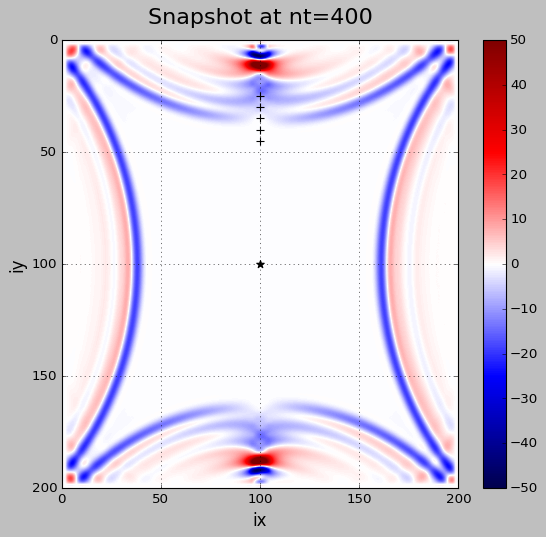

In [80]:
# Make snapshot
timestep = 400

plt.figure(figsize=(8,7))
plt.grid()

plt.imshow(pnew[timestep-1], interpolation='lanczos', animated=True,
           extent=(0,nx,nz,0), aspect="auto", vmin=-50, vmax=50, cmap="seismic")
plt.colorbar()
plt.scatter(irx, irz, marker="+", color="black", s=50)
plt.scatter(isx, isz, marker="*", color="black", s=50)
plt.title("Snapshot at nt={}".format(timestep), size=20, pad=15)
plt.xlabel("ix", size=15); plt.ylabel("iy", size=15)

plt.show()

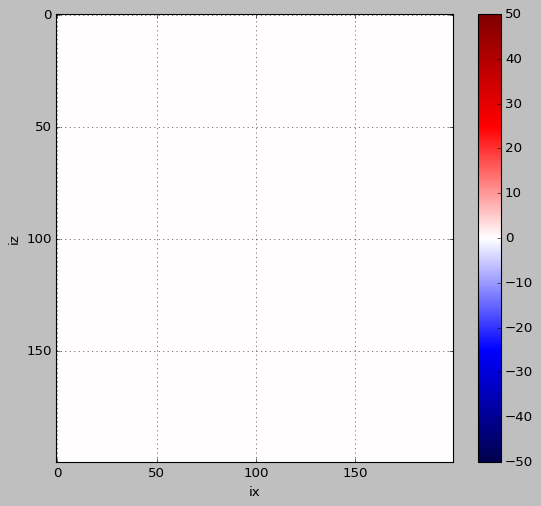

In [93]:
# Initialize plot
p0 = np.empty((nx,nz))

fig = plt.figure(figsize=(8,7))
plt.xlabel('ix')
plt.ylabel('iz')
plot = plt.imshow(p0, vmin=-50, vmax=50, cmap="seismic", aspect="auto")
plt.colorbar()
plt.grid()

In [100]:
def update_plot(n, u_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    u_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    # plot.set_ydata(u_hist[n])
    plot.set_data(u_hist[n])

In [102]:
# Input
input = [nx,nz,nt,dx,dt,c0,isx,isz,ist,f0,isnap,T,nop]
p0 = [p, pold, pnew, pxx, pzz]

# Execute simulation
pnew = borehole_ac2d(input, p0, "bhvertical")

# Create movie
nt = 550
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(pnew,),
                               interval=200)

In [103]:
# Display the video.
HTML(anim.to_html5_video())